In [78]:
import datajoint as dj
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import ipyvolume.pylab as p3
import seaborn as sns

from scipy.stats import gaussian_kde

In [2]:
ta3p100 = dj.create_virtual_module('ta3p100', 'microns_ta3p100')

Connecting cpapadop@10.28.0.34:3306


In [3]:
fetched_mesh = (ta3p100.Mesh & ta3p100.CurrentSegmentation & 'segment_id=648518346341351503').fetch1()

In [4]:
fetched_mesh = ta3p100.Decimation35.fetch(limit=1, as_dict=True)[0]

# Skeleton

In [5]:
# Once I make several, small voxels it would be quite easy to turn that into a skeleton structure by just connecting voxels
# that are next to each other.

# I could use the centroids of the voxels as bone points, and also downsample the bone structure by checking to see how far
# a bone vector strays from the centroids of adjacent voxels, or rather the downstream voxels from a starting voxel.

# If I can scan across the whole mesh and start building regression lines... and correcting and branching off... hmm that might be possible.
# Basically I would start a bone at a vertex, and continue that bone as I scan through the mesh across one axis. If I find a vertex far enough
# away from my current bone then I either start a new bone OR I branch off from the current bone.
# I think that I will basically grant membership of vertices to each bone in order to create the skeleton structure. So I need to keep track
# of which vertices are assigned to each bone. Probably using a dict, and from there I can just append vertices to the bone index. This will
# also allow me to compare 2 bones (and their vertices) with each other by looking at 2 bone indices in the dict.
# I should also make a verification function to see how close the vertices are to their assigned bones.
# Depending on how I merge bones, I might get spines also defined as bones, which might be beneficial.
# Essentially I'm going through a decision tree:
# 1. If I find a vertex on its own, I create a bone.
# 2. If I find a vertex near another vertex, I keep the bone growing.
# 

class Skeleton:
    _bones = list()
    
    def __init__(self, vertices, triangles):
        self._original_vertices = vertices
        self._original_triangles = triangles
        
        self._vertices = vertices
        self._triangles = triangles
    
    @property
    def vertices(self):
        return self._vertices
    
    @property
    def triangles(self):
        return self._triangles
    
    @property
    def _nonisolated_vertices(self):
        unique_vertex_idx = np.unique(self.triangles)
        return self.vertices[unique_vertex_idx]
    
    @property
    def _sorted_vertices(self):
        """
        Returns sorted nonisolated vertices.
        """
        verts = self._nonisolated_vertices
        sorted_idx = verts.T[2].argsort()
        return verts[sorted_idx]
    
    @property
    def bbox(self):
        return np.array([(np.min(axis), np.max(axis)) for axis in self.vertices.T]) # Should I use nonisolated vertices though?
    
    def plot_mesh(self, width=1024, height=1024, **kwargs):
        p3.figure(width=width, height=height)
        p3.plot_trisurf(*self.vertices.T/1000, self.triangles, **kwargs)
        p3.squarelim()
        p3.show()
    
    def plot_verts(self, width=1024, height=1024, targeted_verts=None, **kwargs):
        if targeted_verts is None:
            verts = self.vertices
        else:
            verts = targeted_verts
        
        p3.figure(width=width, height=height)
        p3.scatter(*verts.T/1000, **kwargs)
        p3.squarelim()
        p3.show()
        
    def thick_plane(self, num_planes=50):
        z_space = np.linspace(*self.bbox[2], num=num_planes)

        starting_idx = 0
        partition_edge_idx = list([starting_idx])
        verts = self._sorted_vertices
        for j, z_edge in enumerate(z_space[1:-1]):
            for i, vert in enumerate(verts.T[2][starting_idx:]):
                if vert > z_edge:
                    starting_idx += i
                    partition_edge_idx.append(starting_idx)
                    break
        partition_edge_idx.append(-1) #(len(verts) - 1)
        
        return np.array(partition_edge_idx)
    
    @property
    def bones(self):
        return self._bones
    
    def add_bone(self, starting_point, ending_point):
        # The bones should probably be connected in some way? Though a branching bone might not want to be connected.
        self._bones.append((starting_point, ending_point))
        
    def scan(self, axis='x'):        
        if axis.lower() == 'x':
            axis_idx = 0
        elif axis.lower() == 'y':
            axis_idx = 1
        elif axis.lower() == 'z':
            axis_idx = 2
        else:
            raise ValueError("Invalid value for axis, choose between 'x', 'y', and 'z'.")
            
        verts = self._sorted_vertices
        
        bone_membership = dict()
        for vert in verts:
            pass

In [6]:
# skel = Skeleton()

In [9]:
mesh = Mesh(fetched_mesh['vertices'], fetched_mesh['triangles'])
start = time.time()
mesh.initialize_voxels(10000, fnc_of_bbox_vol=False)
vox_df = mesh.voxel_bboxes_df
time.time() - start, len(mesh.voxels)

(0.23443245887756348, 242)

In [23]:
for vox in vox_df.values:
    vox = vox.reshape((3, 2))
    important_points = 
    break

[[222472.9375   223844.1875  ]
 [196082.34375  196505.921875]
 [ 84391.109375  86258.703125]]


In [62]:
def vertices_along_axis(vertices, edges, axis):
    sorted_idx = vertices.T[axis].argsort()
    axis_verts = vertices[sorted_idx]
    splitter = axis_verts.T[axis].searchsorted(edges)
    vertex_members = np.split(axis_verts, splitter)[1]
    return vertex_members

def vertex_membership(vertices, bbox):
    members = mesh.vertices
    for i, edges in enumerate(bbox):
        members = vertices_along_axis(members, edges, i)
    return members

In [64]:
%timeit vertex_membership(mesh.vertices, vox)

20.3 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
members

array([[222925.5625   , 196491.046875 ,  84391.109375 ],
       [222906.84375  , 196391.796875 ,  84475.84375  ],
       [223002.8125   , 196463.703125 ,  84539.5859375],
       [222834.4375   , 196393.703125 ,  84566.546875 ],
       [222714.1875   , 196453.3125   ,  84588.0625   ],
       [222962.96875  , 196432.765625 ,  84637.8046875],
       [223077.65625  , 196493.609375 ,  84646.9609375],
       [222836.53125  , 196454.46875  ,  84659.4921875],
       [223824.046875 , 196474.59375  ,  85514.5390625],
       [223649.703125 , 196495.328125 ,  85852.65625  ],
       [223678.40625  , 196385.       ,  85876.53125  ],
       [223826.0625   , 196384.203125 ,  85881.53125  ],
       [223742.15625  , 196412.71875  ,  85893.984375 ],
       [223515.234375 , 196328.421875 ,  85895.578125 ],
       [223840.234375 , 196218.375    ,  85967.0625   ],
       [223470.703125 , 196288.421875 ,  85974.75     ],
       [223293.265625 , 196458.671875 ,  85978.6875   ],
       [223787.09375  , 196152.

In [101]:
members.T

array([[222925.5625   , 196491.046875 ,  84391.109375 ],
       [222906.84375  , 196391.796875 ,  84475.84375  ],
       [223002.8125   , 196463.703125 ,  84539.5859375],
       [222834.4375   , 196393.703125 ,  84566.546875 ],
       [222714.1875   , 196453.3125   ,  84588.0625   ],
       [222962.96875  , 196432.765625 ,  84637.8046875],
       [223077.65625  , 196493.609375 ,  84646.9609375],
       [222836.53125  , 196454.46875  ,  84659.4921875],
       [223824.046875 , 196474.59375  ,  85514.5390625],
       [223649.703125 , 196495.328125 ,  85852.65625  ],
       [223678.40625  , 196385.       ,  85876.53125  ],
       [223826.0625   , 196384.203125 ,  85881.53125  ],
       [223742.15625  , 196412.71875  ,  85893.984375 ],
       [223515.234375 , 196328.421875 ,  85895.578125 ],
       [223840.234375 , 196218.375    ,  85967.0625   ],
       [223470.703125 , 196288.421875 ,  85974.75     ],
       [223293.265625 , 196458.671875 ,  85978.6875   ],
       [223787.09375  , 196152.

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'c'
  s)


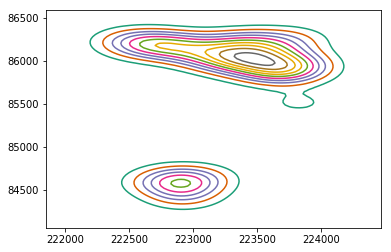

In [104]:
sns.kdeplot(members.T[0], members.T[2], c=members.T[2], cmap='Dark2')

In [105]:
members = vertex_membership(mesh.vertices, vox)
xs = np.linspace(0,8,200)
ys = gaussian_kde(members)
index = np.argmax(ys)
# max_y = ys[index]
# max_x = xs[index]

In [110]:
ys.

3

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


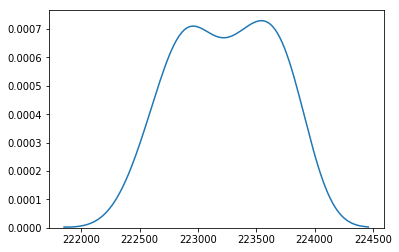

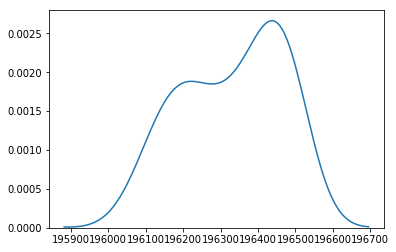

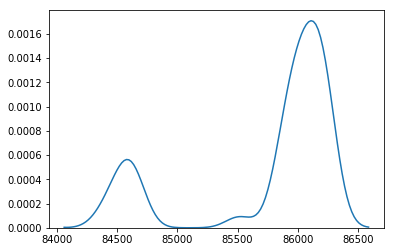

In [77]:
members = vertex_membership(mesh.vertices, vox)
for i in range(3):
    sns.kdeplot(members.T[i])#, bins=50)
    plt.show()

In [45]:
x_edges, y_edges, z_edges = vox
x_members = vertices_along_axis(mesh.vertices, x_edges, 0)
xy_members = vertices_along_axis(x_members, y_edges, 1)
xyz_members = vertices_along_axis(xy_members, z_edges, 2)
len(x_members), len(xy_members), len(xyz_members)

[1944 2325]
[ 0 41]
[ 0 40]


(381, 41, 40)

In [48]:
mesh.vertices[1944:2325]

array([[222472.9375   , 196488.28125  ,  86244.28125  ],
       [222453.796875 , 223222.0625   ,  44050.734375 ],
       [222512.40625  , 222103.046875 ,  44399.3984375],
       ...,
       [223815.9375   , 198075.265625 ,  85509.546875 ],
       [223832.5      , 197701.4375   ,  85787.25     ],
       [223844.1875   , 196464.1875   ,  85391.9375   ]])

In [41]:
mesh.get_bbox(x_members)

array([[222472.9375  , 223843.46875 ],
       [196082.34375 , 224018.046875],
       [ 42235.75    ,  86259.90625 ]])

In [42]:
mesh.get_bbox(xy_members)

array([[222472.9375  , 223840.234375],
       [196082.34375 , 196495.328125],
       [ 84391.109375,  86258.703125]])

In [43]:
mesh.get_bbox(xyz_members)

array([[222472.9375   , 223840.234375 ],
       [196082.34375  , 196495.328125 ],
       [ 84391.109375 ,  86256.7109375]])

In [28]:
x_split

array([[222472.9375   , 196488.28125  ,  86244.28125  ],
       [222473.640625 , 222187.296875 ,  44329.25     ],
       [222478.       , 222339.1875   ,  44137.25     ],
       ...,
       [223841.125    , 197457.796875 ,  86032.09375  ],
       [223843.203125 , 196692.       ,  86247.9453125],
       [223843.46875  , 198183.34375  ,  85861.53125  ]])

In [ ]:
mesh.vertices[]

# Voxel
    - # Next I need to find a way to create a (probably directed) graph structure from the adjacent voxels.
    - # Which means that I should have a structure that holds all of the Voxels together and can query their edges. Perhaps throw their bboxes into a pandas dataframe.

In [49]:
# I should be able to allow it to Voxelize only certain parts of the mesh by changing the input BBox.

# Due to the odd shape of some of these neurons and their parts, I might really just want to use rectangular shapes that can be rotated...
# but at that point wouldn't it make more sense to create skeletons? If I figure out how to do that it would make my life (and getting
# accurate minimum distance measures) much easier. Though it would be difficult to extract the info needed for those skeletons.

# I can turn this into a skeleton by merging touching voxels, or by simple connecting the centroids of voxels by some rule (basically make a tree structure
# starting from one centroid).

# I can merge voxels by checking to see how much their adjacent faces are overlapping (and I should also ensure they don't get too big, by keeping a threshold
# either on the volume/size it can be, or by restricting it by how much empty space I'd be adding in).

class Mesh:
    def __init__(self, vertices, triangles, ignore_isolated_vertices=True):
        self._original_vertices = vertices
        self._original_triangles = triangles
        
        self._vertices = vertices
        self._triangles = triangles
        self._ignore_isolated = ignore_isolated_vertices
        
        self._voxels = list()
    
    class Voxel: # Override some operators to allow direct manipulation to the bbox inside.
        """
        If I really want Voxels that are cubes, I can push the boundaries of the Mesh bounding box to fit what I need (to allow the cubes to fit edge to edge).
        """
        def __init__(self, bbox):
            self._bbox = bbox
            
        @property
        def bbox(self):
            return self._bbox
        
        @bbox.setter
        def bbox(self, bbox):
            if not isinstance(bbox, np.ndarray):
                bbox = np.array(bbox)
            
            if bbox.shape == (3, 2):
                self._bbox = bbox
            else:
                raise ValueError("Bounding box is not in required form which is: array-like with shape (3, 2).")
            
        @property
        def centroid(self):
            return self.bbox.T.mean(axis=0)
        
        def __str__(self):
            return str(self.bbox)
    
    @property
    def voxels(self):
        return self._voxels
    
    @voxels.setter
    def voxels(self, voxels):
        self._voxels = voxels
        
    @property
    def voxel_bboxes(self):
        return np.array([voxel.bbox for voxel in self.voxels])
    
    @property
    def voxel_bboxes_df(self):
        bboxes = self.voxel_bboxes
        return pd.DataFrame(data=bboxes.reshape((len(bboxes), 6)),
                            columns=['x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max'])
    
    @property
    def vertices(self): # Could "potentially" have the ignore_isolated_vertices_check in here... but it would mess up indices, so put in
        # another property entirely.
        return self._vertices
    
    @property
    def triangles(self):
        return self._triangles
    
    @property
    def _nonisolated_vertices(self):
        unique_vertex_idx = np.unique(self.triangles)
        return self.vertices[unique_vertex_idx]
    
    @property
    def bbox(self):
        return np.array([(np.min(axis), np.max(axis)) for axis in self.vertices.T])
    
    @property
    def index_method(self):
        raise NotImplementedError("I kind of want this to be able to return all vertices within certain ranges (basically vertices within a bbox).")
    
    @staticmethod
    def get_bbox(vertices):
        return np.array([(np.min(axis), np.max(axis)) for axis in vertices.T])
        
    def plot_mesh(self, width=1024, height=1024, **kwargs):
        p3.figure(width=width, height=height)
        p3.plot_trisurf(*self.vertices.T/1000, self.triangles, **kwargs)
        p3.squarelim()
        p3.show()
    
    def generate_voxel_lines(self):
        bboxes = np.array([voxel.bbox for voxel in self.voxels])
        return np.array([[[xs[0], ys[0], zs[0]],
                         [xs[0], ys[0], zs[1]],
                         [xs[0], ys[1], zs[1]],
                         [xs[0], ys[1], zs[0]],
                         [xs[0], ys[0], zs[0]],

                         [xs[1], ys[0], zs[0]],
                         [xs[1], ys[0], zs[1]],
                         [xs[1], ys[1], zs[1]],
                         [xs[1], ys[1], zs[0]],
                         [xs[1], ys[0], zs[0]],

                         [xs[0], ys[0], zs[0]],
                         [xs[0], ys[0], zs[1]],
                         [xs[1], ys[0], zs[1]],
                         [xs[1], ys[0], zs[0]],
                         [xs[0], ys[0], zs[0]],

                         [xs[0], ys[1], zs[0]],
                         [xs[0], ys[1], zs[1]],
                         [xs[1], ys[1], zs[1]],
                         [xs[1], ys[1], zs[0]],
                         [xs[0], ys[1], zs[0]]] for xs, ys, zs in bboxes])
    
    def plot_voxels(self, width=1024, height=1024):
        fig = p3.figure(width=width, heigh=height)
        [p3.plot(*lines.T/1000, color='blue') for lines in self.generate_voxel_lines()]
        p3.squarelim()
        p3.show()
        
#         return fig
    
    def plot_mesh_and_voxels(self, width=1024, height=1024, **kwargs):
        p3.figure(width=width, height=height)
        p3.plot_trisurf(*self.vertices.T/1000, self.triangles, **kwargs)
        [p3.plot(*lines.T/1000, color='blue') for lines in self.generate_voxel_lines()]
        
        style = {'axes': {'visible': False,
          'label': {'visible': False, 'color': 'black'},
          'ticklabel': {'visible': False, 'color': 'black'},
          'color': 'black'},
         'box': {'visible': False},
         'background-color': 'black'}
        p3.xyzlabel(' ', ' ', ' ')
        f = p3.gcf()
        f.style = style
        
        p3.squarelim()
        p3.show()    
    
    def merge_touching_voxels(self):
        raise NotImplementedError
        
    def debug(self, voxel_side_length=1000):
        n_splits = np.array([((axis[1] - axis[0]) / voxel_side_length) + 1 for axis in self.bbox], np.uint32)

        x_split, y_split, z_split = [np.linspace(minimum, maximum, num=axis_splits)
                                     for (minimum, maximum), axis_splits in zip(self.bbox, n_splits)]
        
        bboxes = list()
        x_pairs = np.array([(x_split[i], x_split[i+1]) for i in range(len(x_split) - 1)])
        y_pairs = np.array([(y_split[i], y_split[i+1]) for i in range(len(y_split) - 1)])
        z_pairs = np.array([(z_split[i], z_split[i+1]) for i in range(len(z_split) - 1)])
        for xs in x_pairs:
            for ys in y_pairs:
                for zs in z_pairs:
                    bboxes.append((xs, ys, zs))
        bboxes = np.array(bboxes)
        
        bbox_lines = np.array([[[xs[0], ys[0], zs[0]],
                         [xs[0], ys[0], zs[1]],
                         [xs[0], ys[1], zs[1]],
                         [xs[0], ys[1], zs[0]],
                         [xs[0], ys[0], zs[0]],

                         [xs[1], ys[0], zs[0]],
                         [xs[1], ys[0], zs[1]],
                         [xs[1], ys[1], zs[1]],
                         [xs[1], ys[1], zs[0]],
                         [xs[1], ys[0], zs[0]],

                         [xs[0], ys[0], zs[0]],
                         [xs[0], ys[0], zs[1]],
                         [xs[1], ys[0], zs[1]],
                         [xs[1], ys[0], zs[0]],
                         [xs[0], ys[0], zs[0]],

                         [xs[0], ys[1], zs[0]],
                         [xs[0], ys[1], zs[1]],
                         [xs[1], ys[1], zs[1]],
                         [xs[1], ys[1], zs[0]],
                         [xs[0], ys[1], zs[0]]] for xs, ys, zs in bboxes])
        
        p3.figure(width=1024, height=1024)
        p3.plot_trisurf(*self.vertices.T/1000, self.triangles)
        [p3.plot(*lines.T/1000, color='blue') for lines in bbox_lines]
        p3.squarelim()
        p3.show()
        
        return bboxes
    
    # Voxels are still collapsing wtf
    def restrict_bboxes(self, voxel_side_length=1000): # Can improve the cubimetrics (fake word for splitting it into cubes)
        nonisolated_vertices = self._nonisolated_vertices
        
        # I should try rounding the mesh bbox up to the nearest level that is evenly divisible by the voxel_side_length
        # that way I can actually make it split into cubes nicely.
        
        n_splits = np.array([((axis[1] - axis[0]) / voxel_side_length) + 1 for axis in self.bbox], np.uint32)
#         n_splits = [11] * 3
    
        x_edges, y_edges, z_edges = [np.linspace(minimum, maximum, num=axis_splits)[1:-1]
                                     for (minimum, maximum), axis_splits in zip(self.bbox, n_splits)]
                
        bboxes = list()
        
        sorted_idx = nonisolated_vertices.T[0].argsort()
        x_verts = nonisolated_vertices[sorted_idx]
        splitter = x_verts.T[0].searchsorted(x_edges)
        x_split = np.split(x_verts, splitter)
        for x_block in x_split:
            if len(x_block) > 0:
                sorted_idx = x_block.T[1].argsort()
                y_verts = x_block[sorted_idx]
                splitter = y_verts.T[1].searchsorted(y_edges)
                y_split = np.split(y_verts, splitter)
                if len(y_split) > 0:
                    for y_block in y_split:
                        if len(y_block) > 0:
                            sorted_idx = y_block.T[2].argsort()
                            z_verts = y_block[sorted_idx]
                            splitter = z_verts.T[2].searchsorted(z_edges)
                            z_split = np.split(z_verts, splitter)
                            if len(z_split) > 0:
                                for z_block in z_split:
                                    if len(z_block) > 0:
                                        bboxes.append(self.get_bbox(z_block))
            
        return bboxes
    
    def initialize_voxels(self, voxel_side_length=1000, fnc_of_bbox_vol=False):
        if fnc_of_bbox_vol:
            raise NotImplementedError("It doesn't work well for small axons, it creates a lot of collapsed voxels due to the voxel size being too small.")
            mesh_bbox = self.bbox
            x, y, z = -np.subtract(*mesh_bbox.T/1000)
            voxel_side_length = (x*y*z) / 3 / 150
            print(voxel_side_length)
        
        bboxes = self.restrict_bboxes(voxel_side_length=voxel_side_length)
        self._voxels = [self.Voxel(bbox) for bbox in bboxes]
        return self.voxels

In [50]:
mesh = Mesh(fetched_mesh['vertices'], fetched_mesh['triangles'])
start = time.time()
mesh.initialize_voxels(10000, fnc_of_bbox_vol=False)
time.time() - start, len(mesh.voxels)

(0.21059107780456543, 242)

In [51]:
mesh.voxel_bboxes_df

,x_min,x_max,y_min,y_max,z_min,z_max
0,222472.937500,223844.187500,196082.343750,196505.921875,84391.109375,86258.703125
1,222438.781250,223884.828125,196520.796875,198211.140625,84350.859375,86259.906250
2,213521.062500,223295.984375,220783.906250,223968.203125,40977.812500,43539.046875
3,213431.765625,223880.906250,220669.250000,224286.296875,43541.632812,46874.218750
4,223905.875000,234191.625000,194668.812500,196510.656250,82794.031250,86267.625000
5,223893.625000,234338.640625,196511.468750,198435.218750,82962.406250,86261.250000
6,226376.687500,233578.718750,221116.468750,223938.125000,42398.500000,43538.679688
7,223891.750000,234307.187500,220157.671875,224849.000000,43542.968750,48102.109375
8,235527.156250,236248.718750,196134.250000,196490.375000,82620.296875,82833.468750
9,234344.218750,244789.734375,196516.968750,202268.234375,79655.593750,85540.687500


In [52]:
mesh.plot_mesh_and_voxels()

# Cube Voxel

In [60]:
class CubeVoxel:
    def __init__(self, vertices):
        self.vertices = vertices
        
    @property
    def bbox(self):
        return self._bbox

    @bbox.setter
    def bbox(self, bbox):
        if not isinstance(bbox, np.ndarray):
            bbox = np.array(bbox)

        if bbox.shape == (3, 2):
            self._bbox = bbox
        else:
            raise ValueError("Bounding box is not in required form which is: array-like with shape (3, 2).")
    
    @property
    def centroid(self):
        return self.bbox.mean(axis=0)
    
    @property
    def vertices(self):
        return self._vertices
    
    @vertices.setter
    def vertices(self, vertices):
        self.bbox = np.array([(np.min(axis), np.max(axis)) for axis in vertices.T])
        self._vertices = vertices
        
    def split(self, n_splits=2, method='half'):
#         if method == 'half':
#             pass
        
        x_edges, y_edges, z_edges = [np.linspace(minimum, maximum, num=axis_splits)[1:-1]
                                     for (minimum, maximum), axis_splits in zip(self.bbox, [n_splits]*3)]
        
        print(x_edges, y_edges, z_edges)
        
        verts = self.vertices
        
        vert_blocks = list()
        
        sorted_idx = verts.T[0].argsort()
        x_verts = verts[sorted_idx]
        splitter = x_verts.T[0].searchsorted(x_edges)
        x_split = np.split(x_verts, splitter)
        for x_block in x_split:
            if len(x_block) > 0:
                sorted_idx = x_block.T[1].argsort()
                y_verts = x_block[sorted_idx]
                splitter = y_verts.T[1].searchsorted(y_edges)
                y_split = np.split(y_verts, splitter)
                if len(y_split) > 0:
                    for y_block in y_split:
                        if len(y_block) > 0:
                            sorted_idx = y_block.T[2].argsort()
                            z_verts = y_block[sorted_idx]
                            splitter = z_verts.T[2].searchsorted(z_edges)
                            z_split = np.split(z_verts, splitter)
                            if len(z_split) > 0:
                                for z_block in z_split:
                                    if len(z_block) > 0:
                                        vert_blocks.append(z_block)
            
        return vert_blocks
    
    def return_voxels(self, n_splits=2):
        vert_blocks = self.split(n_splits) 
        return [CubeVoxel(vert_block) for vert_block in vert_blocks]

In [67]:
unique_vertex_idx = np.unique(fetched_mesh['triangles'])
nonisolated_vertices = fetched_mesh['vertices'][unique_vertex_idx]
cv = CubeVoxel(nonisolated_vertices)
bboxes = [cube_voxel.bbox for cube_voxel in cv.return_voxels(16)]

[213431.765625   228067.33541667 242702.90520833 257338.475
 271974.04479167 286609.61458333 301245.184375   315880.75416667
 330516.32395833 345151.89375    359787.46354167 374423.03333333
 389058.603125   403694.17291667 418329.74270833 432965.3125    ] [145055.953125   156033.02083333 167010.08854167 177987.15625
 188964.22395833 199941.29166667 210918.359375   221895.42708333
 232872.49479167 243849.5625     254826.63020833 265803.69791667
 276780.765625   287757.83333333 298734.90104167 309711.96875   ] [  813.52148438  6510.46171875 12207.40195312 17904.3421875
 23601.28242187 29298.22265625 34995.16289062 40692.103125
 46389.04335937 52085.98359375 57782.92382812 63479.8640625
 69176.80429687 74873.74453125 80570.68476563 86267.625     ]


In [68]:
def generate_voxel_lines(voxels):
    bboxes = np.array([voxel.bbox for voxel in voxels])
    return np.array([[[xs[0], ys[0], zs[0]],
                         [xs[0], ys[0], zs[1]],
                         [xs[0], ys[1], zs[1]],
                         [xs[0], ys[1], zs[0]],
                         [xs[0], ys[0], zs[0]],

                         [xs[1], ys[0], zs[0]],
                         [xs[1], ys[0], zs[1]],
                         [xs[1], ys[1], zs[1]],
                         [xs[1], ys[1], zs[0]],
                         [xs[1], ys[0], zs[0]],

                         [xs[0], ys[0], zs[0]],
                         [xs[0], ys[0], zs[1]],
                         [xs[1], ys[0], zs[1]],
                         [xs[1], ys[0], zs[0]],
                         [xs[0], ys[0], zs[0]],

                         [xs[0], ys[1], zs[0]],
                         [xs[0], ys[1], zs[1]],
                         [xs[1], ys[1], zs[1]],
                         [xs[1], ys[1], zs[0]],
                         [xs[0], ys[1], zs[0]]] for xs, ys, zs in bboxes])

In [69]:
p3.figure(width=1024, height=1024)
p3.plot_trisurf(*fetched_mesh['vertices'].T/1000, fetched_mesh['triangles'])
[p3.plot(*lines.T/1000, color='blue') for lines in generate_voxel_lines(cv.return_voxels(2))]
p3.squarelim()
p3.show() 

[213431.765625 432965.3125  ] [145055.953125 309711.96875 ] [  813.52148438 86267.625     ]
